In [1]:
import numpy as np
import pandas as pd
import sys

from cmlreaders import CMLReader, get_data_index
from scipy import stats
import cmlreaders as cml
from matplotlib import pyplot as plt
from mne import Epochs, create_info
from mne.io import RawArray
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from scipy import stats
import mne
from mne import create_info, EpochsArray
import os
import numpy as np
import mne
from mne import create_info, EpochsArray

In [2]:
exp = 'FR2'
pd.set_option('display.max_rows', None)

subjects=['R1016M' ,'R1024E' ,'R1026D' ,'R1028M' ,'R1029W' ,'R1031M' ,'R1036M', 'R1039M'
 ,'R1041M' ,'R1042M','R1050M' ,'R1060M', 'R1067P' ,'R1069M' ,'R1074M', 'R1092J',
 'R1157C' ,'R1180C', 'R1192C']
subjects=['R1001P', 'R1002P' ,'R1003P' , 'R1016M', 'R1018P' ,'R1020J', 'R1022J',
 'R1023J' ,'R1024E' ,'R1026D', 'R1027J', 'R1028M', 'R1030J', 'R1031M', 'R1033D',
 'R1035M' ,'R1036M' ,'R1042M', 'R1048E' ,'R1050M' ,'R1052E' ,'R1053M','R1056M',
 'R1060M' ,'R1069M' ,'R1070T' ,'R1074M' ,'R1077T', 'R1085C' ,'R1101T', 'R1111M',
 'R1112M' ,'R1115T', 'R1150J', 'R1176M' ,'R1177M', 'R1184M']
subjects=['R1124J' ,'R1145J' ,'R1154D' ,'R1161E', 'R1163T' ,'R1166D', 'R1170J' ,'R1195E'
 'R1200T' ,'R1201P', 'R1202M', 'R1204T', 'R1217T' ,'R1223E', 'R1230J' ,'R1235E',
 'R1236J' ,'R1293P']


In [18]:
exp = 'FR2'
df = cml.get_data_index()
df_select=df[df['experiment'] == exp]
allsubject=df_select['subject'].unique()
print(f'{allsubject}')

['R1001P' 'R1002P' 'R1003P' 'R1006P' 'R1016M' 'R1018P' 'R1020J' 'R1022J'
 'R1023J' 'R1024E' 'R1026D' 'R1027J' 'R1028M' 'R1030J' 'R1031M' 'R1033D'
 'R1035M' 'R1036M' 'R1042M' 'R1048E' 'R1050M' 'R1052E' 'R1053M' 'R1056M'
 'R1060M' 'R1069M' 'R1070T' 'R1074M' 'R1077T' 'R1085C' 'R1101T' 'R1111M'
 'R1112M' 'R1115T' 'R1150J' 'R1176M' 'R1177M' 'R1184M']


In [14]:
import os
import numpy as np
import mne
from mne import create_info, EpochsArray
import cmlreaders as cml


# Define parameters
exp = 'FR2'
duration_encoding = 1600  # Define your encoding duration in ms

whole_df = cml.CMLReader.get_data_index()

# Create directories for saving results
os.makedirs('eeg_results', exist_ok=True)
os.makedirs('eeg_results/trial_level', exist_ok=True)  # NEW: For trial-level data
os.makedirs('eeg_results/subject_averaged', exist_ok=True)  # NEW: For subject averages

subjects=['R1001P', 'R1002P' ,'R1003P' , 'R1016M', 'R1018P' ,'R1020J', 'R1022J',
 'R1023J' ,'R1024E' ,'R1026D', 'R1027J', 'R1028M', 'R1030J', 'R1031M', 'R1033D',
 'R1035M' ,'R1036M' ,'R1042M', 'R1048E' ,'R1050M' ,'R1052E' ,'R1053M','R1056M',
 'R1060M' ,'R1069M' ,'R1070T' ,'R1074M' ,'R1077T', 'R1085C' ,'R1101T', 'R1111M',
 'R1112M' ,'R1115T', 'R1150J', 'R1176M' ,'R1177M', 'R1184M']
# ============ Storage for subject-level data ============
# Store subject-wise averaged data for between-subject analyses
subject_power_recalled = []
subject_power_forgotten = []
subject_ids = []
subject_trial_counts = []  # NEW: Track trial counts per subject
# ========================================================

# Loop through each subject
for subject in subjects:
    print(f"\n{'='*60}")
    print(f"Processing subject: {subject}")
    print(f"{'='*60}")
    subject_recalled_power = []
    subject_forgotten_power = []
    try:
        # Get subject data
        sub_df = whole_df.query('experiment == @exp and subject == @subject')
        sessions = sub_df['session'].unique()
        
        if len(sessions) == 0:
            print(f"  No sessions found for subject {subject}")
            continue
        
        for session_idx, session in enumerate(sessions):
            print(f"\nProcessing session: {session}")
            
            try:
                # Load session data
                reader = cml.CMLReader(subject, exp, session=session)
                evs = reader.load('task_events')
                evs_stim = evs[evs['stim_list'] == False]
                WORDS_rows = evs_stim[evs_stim['type'] == 'WORD']
                
                if len(WORDS_rows) == 0:
                    print(f"  No WORD events found in session {session}")
                    continue
                
                channels = reader.load("pairs")
                
                # Analyze stimuli - ENCODING ONLY
                result_encoding = WORDS_rows
                
                # Get recall labels
                recalled_label = result_encoding['recalled'].reset_index(drop=True)
                
                # Select temporal channels from channels dataframe
                if 'avg.region' in channels.columns:
                    temporal_channel_mask = channels['avg.region'].str.contains('temporal', na=False, case=False)
                    all_temporal_channel_indices = channels[temporal_channel_mask].index.tolist()
                else:
                    print(f"  Warning: 'avg.region' column not found in channels dataframe")
                    print(f"  Available columns: {channels.columns.tolist()}")
                    all_temporal_channel_indices = []
                
                # Use all temporal channels
                temporal_channel_indices = all_temporal_channel_indices
                
                print(f"  Found {len(temporal_channel_indices)} temporal channels")
                
                # Skip if no temporal channels found
                if len(temporal_channel_indices) == 0:
                    print(f"  Skipping session - no temporal channels found")
                    continue
                
                # Load EEG data - ENCODING ONLY
                baseline_ms = 3000
                buffer_ms = 1000
                eeg_container_encoding = reader.load_eeg(
                    result_encoding, 
                    -(baseline_ms + buffer_ms), 
                    duration_encoding + baseline_ms + buffer_ms, 
                    scheme=channels
                )
                
                eeg_encoding = eeg_container_encoding.data
                sr = eeg_container_encoding.samplerate
                
                # Create MNE info structure
                channels['channel_type'] = 'seeg'
                sfreq = sr
                ch_names = list(channels['label'])
                ch_types = list(channels['channel_type'])
                info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
                
                # Calculate proper tmin based on your time window
                tmin = -(baseline_ms + buffer_ms) / 1000.0  # Convert to seconds
                
                # Create epochs
                eeg_encoding_epochs = EpochsArray(eeg_encoding.data, info, tmin=tmin, verbose=False)
                
                # NEW: Add filtering before time-frequency analysis
                print(f"  Applying filters...")
                eeg_encoding_epochs = eeg_encoding_epochs.copy().filter(l_freq=0.5, h_freq=None, verbose=False)
         
                
                # Resample
                freqs = [2, 4, 6, 8, 10, 12, 14, 16]
                newfreq = 50
                eeg_encoding_epochs = eeg_encoding_epochs.copy().resample(newfreq, verbose=False)
                
                # Apply time-frequency analysis
                print(f"  Computing time-frequency decomposition...")
                power_eeg_encoding_epochs = mne.time_frequency.tfr_morlet(
                    eeg_encoding_epochs, 
                    freqs=freqs, 
                    n_cycles=5, 
                    return_itc=False, 
                    average=False,
                    verbose=False
                )
                
                # Apply baseline correction (CRITICAL for proper analysis)
                baseline_start = -2 # -4.0 seconds
                baseline_end = -1.5 # Start of encoding
                power_eeg_encoding_epochs.apply_baseline(
                    baseline=(baseline_start, baseline_end), 
                    mode='logratio',  # Converts to dB: 10*log10(power/baseline_power)
                    verbose=False
                )
                
                # Extract power for temporal channels and split by recall
                # Shape: (trials, channels, freqs, times) -> average over channels -> (trials, freqs, times)
                power = power_eeg_encoding_epochs.data[:, temporal_channel_indices, :, :].mean(axis=1)
                recalled = recalled_label.values.astype(bool)
                
                # Append to subject's trial lists
                if recalled.sum() > 0:
                    subject_recalled_power.append(power[recalled])
                if (~recalled).sum() > 0:
                    subject_forgotten_power.append(power[~recalled])
                    
            except Exception as e:
                print(f"  Error processing session {session}: {str(e)}")
                continue
        
        # Average across all trials for this subject (only if we have data for BOTH conditions)
        if len(subject_recalled_power) > 0 and len(subject_forgotten_power) > 0:
            # Concatenate all recalled trials across sessions
            all_recalled_trials = np.concatenate(subject_recalled_power, axis=0)
            all_forgotten_trials = np.concatenate(subject_forgotten_power, axis=0)
            
            # ============ NEW: SAVE TRIAL-LEVEL DATA ============
            np.save(f'eeg_results/trial_level/{subject}_recalled_trials.npy', all_recalled_trials)
            np.save(f'eeg_results/trial_level/{subject}_forgotten_trials.npy', all_forgotten_trials)
            print(f"\n✓ Saved trial-level data:")
            print(f"  {subject}_recalled_trials.npy: shape {all_recalled_trials.shape}")
            print(f"  {subject}_forgotten_trials.npy: shape {all_forgotten_trials.shape}")
            # ====================================================
            
            # Average over trials
            subject_avg_recalled = all_recalled_trials.mean(axis=0)  # Average over trials
            subject_avg_forgotten = all_forgotten_trials.mean(axis=0)  # Average over trials
            
            # Store for group analysis
            subject_power_recalled.append(subject_avg_recalled)
            subject_power_forgotten.append(subject_avg_forgotten)
            
            # Store subject ID and trial counts
            subject_ids.append(subject)
            subject_trial_counts.append({
                'subject': subject,
                'n_recalled': len(all_recalled_trials),
                'n_forgotten': len(all_forgotten_trials),
                'n_total': len(all_recalled_trials) + len(all_forgotten_trials)
            })
            
            # ============ SAVE SUBJECT-AVERAGED DATA ============
            np.save(f'eeg_results/subject_averaged/{subject}_recalled_power.npy', subject_avg_recalled)
            np.save(f'eeg_results/subject_averaged/{subject}_forgotten_power.npy', subject_avg_forgotten)
            print(f"✓ Saved subject-averaged data:")
            print(f"  {subject}_recalled_power.npy: shape {subject_avg_recalled.shape}")
            print(f"  {subject}_forgotten_power.npy: shape {subject_avg_forgotten.shape}")
            # ====================================================
            
            print(f"\nSubject {subject} summary:")
            print(f"  Total recalled trials: {len(all_recalled_trials)}")
            print(f"  Total forgotten trials: {len(all_forgotten_trials)}")
        else:
            print(f"\nSubject {subject} skipped - missing recalled or forgotten trials")
            
    except Exception as e:
        print(f"Error processing subject {subject}: {str(e)}")
        continue

# ============ Subject-level analysis ============
print("\n" + "="*60)
print("Subject-level analysis complete")
print("="*60)
print(f"Total subjects with both recalled and forgotten data: {len(subject_ids)}")

# Convert to arrays for further analysis and save
if len(subject_power_recalled) > 0:
    subject_power_recalled = np.array(subject_power_recalled)  # (n_subjects, freqs, times)
    subject_power_forgotten = np.array(subject_power_forgotten)  # (n_subjects, freqs, times)
    
    print(f"\nGroup-level data shapes:")
    print(f"  Recalled power: {subject_power_recalled.shape}")
    print(f"  Forgotten power: {subject_power_forgotten.shape}")
    
    # Save group-level averaged data
    np.save('eeg_results/all_subjects_recalled.npy', subject_power_recalled)
    np.save('eeg_results/all_subjects_forgotten.npy', subject_power_forgotten)
    np.save('eeg_results/subject_ids.npy', np.array(subject_ids))
    
    # NEW: Save metadata
    # Note: We need to get times and freqs from the last processed subject
    # In a real scenario, you'd want to save these during processing
    # For now, we'll just note what should be saved
    print(f"\n✓ Saved group-level data:")
    print(f"  all_subjects_recalled.npy")
    print(f"  all_subjects_forgotten.npy")
    print(f"  subject_ids.npy")
    
    # NEW: Save trial counts
    import json
    with open('eeg_results/trial_counts.json', 'w') as f:
        json.dump(subject_trial_counts, f, indent=2)
    print(f"  trial_counts.json")
    
    # NEW: Print trial count summary
    print(f"\nTrial count summary:")
    for tc in subject_trial_counts:
        print(f"  {tc['subject']}: {tc['n_recalled']} recalled, {tc['n_forgotten']} forgotten")
    
else:
    print("\n⚠ No data to save - no subjects had both recalled and forgotten trials")

# ============ NEW: Save metadata ============
# You should save these during processing, but here's what you need:
print("\n" + "="*60)
print("IMPORTANT: Don't forget to save metadata!")
print("="*60)
print("You should save:")
print("  - times: power_eeg_encoding_epochs.times")
print("  - freqs: power_eeg_encoding_epochs.freqs") 
print("  - sfreq: newfreq (50)")
print("  - baseline_ms, duration_encoding, buffer_ms")
print("="*60)


Processing subject: R1016M

Processing session: 0
  Found 6 temporal channels


/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/cmlreaders/readers/electrodes.py:238: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))


  Applying filters...
  Computing time-frequency decomposition...

✓ Saved trial-level data:
  R1016M_recalled_trials.npy: shape (18, 8, 480)
  R1016M_forgotten_trials.npy: shape (30, 8, 480)
Error processing subject R1016M: 'numpy.ndarray' object has no attribute 'append'

Processing subject: R1024E

Processing session: 0
  Found 34 temporal channels


/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/cmlreaders/readers/electrodes.py:238: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))


  Applying filters...
  Computing time-frequency decomposition...

Processing session: 1
  Found 34 temporal channels


/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/cmlreaders/readers/electrodes.py:238: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))


  Applying filters...
  Computing time-frequency decomposition...

✓ Saved trial-level data:
  R1024E_recalled_trials.npy: shape (58, 8, 480)
  R1024E_forgotten_trials.npy: shape (62, 8, 480)
Error processing subject R1024E: 'numpy.ndarray' object has no attribute 'append'

Processing subject: R1026D

Processing session: 0
  Found 0 temporal channels
  Skipping session - no temporal channels found

Processing session: 1
  Found 0 temporal channels
  Skipping session - no temporal channels found

Processing session: 2
  Found 0 temporal channels
  Skipping session - no temporal channels found

Subject R1026D skipped - missing recalled or forgotten trials

Processing subject: R1028M

Processing session: 0
  Found 30 temporal channels


/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/cmlreaders/readers/electrodes.py:238: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/cmlreaders/readers/electrodes.py:238: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/cmlreaders/readers/electrodes.py:238: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/cmlreaders/readers/electrodes.py:238: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))


  Applying filters...
  Computing time-frequency decomposition...

✓ Saved trial-level data:
  R1028M_recalled_trials.npy: shape (36, 8, 480)
  R1028M_forgotten_trials.npy: shape (12, 8, 480)
Error processing subject R1028M: 'numpy.ndarray' object has no attribute 'append'

Subject-level analysis complete
Total subjects with both recalled and forgotten data: 12

Group-level data shapes:
  Recalled power: (12, 8, 480)
  Forgotten power: (12, 8, 480)

✓ Saved group-level data:
  all_subjects_recalled.npy
  all_subjects_forgotten.npy
  subject_ids.npy
  trial_counts.json

Trial count summary:
  R1031M: 14 recalled, 46 forgotten
  R1036M: 44 recalled, 64 forgotten
  R1039M: 10 recalled, 26 forgotten
  R1042M: 34 recalled, 26 forgotten
  R1050M: 12 recalled, 24 forgotten
  R1060M: 14 recalled, 34 forgotten
  R1067P: 19 recalled, 41 forgotten
  R1069M: 21 recalled, 39 forgotten
  R1092J: 22 recalled, 38 forgotten
  R1157C: 25 recalled, 35 forgotten
  R1180C: 16 recalled, 44 forgotten
  R1192

In [17]:
np.shape(recalled_power)

(12, 8, 480)

Recalled power shape: (12, 8, 480)
Forgotten power shape: (12, 8, 480)
Number of subjects: 12
Time range: -4.00s to 5.60s
Frequencies: [ 2  4  6  8 10 12 14 16]

Running cluster-based permutation test...
This may take a few minutes...
T-values range: -3.79 to 3.47
Using a threshold of 4.300950
Cluster test error: If adjacency matrix is given, it must be a SciPy sparse matrix.
Falling back to t-values only


<ipython-input-15-6d7f0974f689>:114: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  out_type='mask'



✓ Saved figure: eeg_results/time_frequency_heatmaps.png


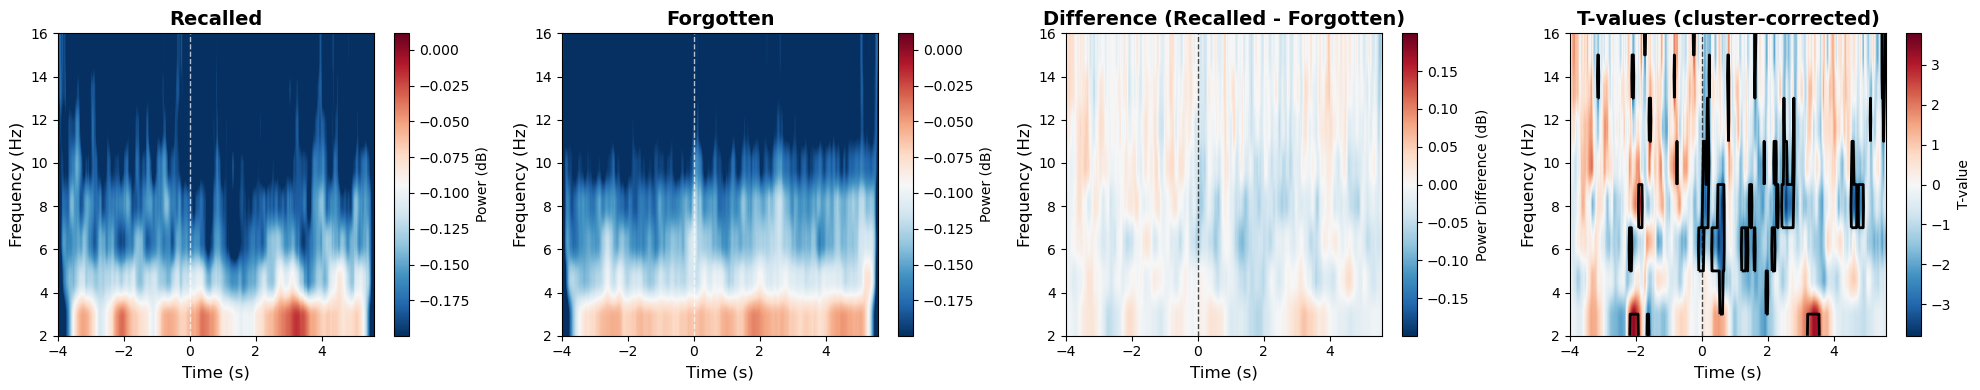


SUMMARY STATISTICS
Recalled power (mean ± std): -0.175 ± 0.088 dB
Forgotten power (mean ± std): -0.166 ± 0.072 dB
Difference (mean ± std): -0.009 ± 0.023 dB
T-value range: -3.79 to 3.47
Significant time-frequency points: 214 / 3840 (5.6%)


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mne.stats import permutation_cluster_test
from scipy import stats

# Load the group-level data
recalled_power = np.load('eeg_results/all_subjects_recalled.npy')  # (n_subjects, freqs, times)
forgotten_power = np.load('eeg_results/all_subjects_forgotten.npy')  # (n_subjects, freqs, times)
subject_ids = np.load('eeg_results/subject_ids.npy')

print(f"Recalled power shape: {recalled_power.shape}")
print(f"Forgotten power shape: {forgotten_power.shape}")
print(f"Number of subjects: {len(subject_ids)}")

# Calculate the difference (SME - Subsequent Memory Effect)
difference = recalled_power.mean(axis=0) - forgotten_power.mean(axis=0)

# Reconstruct time and frequency arrays based on your code parameters
# From your code: baseline_ms=3000, buffer_ms=1000, duration_encoding=1600, newfreq=50
baseline_ms = 3000
buffer_ms = 1000
duration_encoding = 1600
newfreq = 50

# Total time window
total_time_ms = baseline_ms + buffer_ms + duration_encoding + baseline_ms + buffer_ms
tmin = -(baseline_ms + buffer_ms) / 1000.0  # in seconds
tmax = (duration_encoding + baseline_ms + buffer_ms) / 1000.0

# Create time array
n_times = recalled_power.shape[2]
times = np.linspace(tmin, tmax, n_times)

# Frequencies from your code
freqs = np.array([2, 4, 6, 8, 10, 12, 14, 16])

print(f"Time range: {times[0]:.2f}s to {times[-1]:.2f}s")
print(f"Frequencies: {freqs}")

# ============ CLUSTER-BASED PERMUTATION TEST ============
print("\nRunning cluster-based permutation test...")
print("This may take a few minutes...")

# Reshape data for permutation test: (n_subjects, n_freqs * n_times)
n_subjects = recalled_power.shape[0]
n_freqs = recalled_power.shape[1]
n_times_actual = recalled_power.shape[2]

# Create observation arrays (difference for each subject)
X = [recalled_power[i].flatten() for i in range(n_subjects)]
Y = [forgotten_power[i].flatten() for i in range(n_subjects)]

# Compute paired t-test for each time-frequency point
t_values = np.zeros((n_freqs, n_times_actual))
p_values = np.zeros((n_freqs, n_times_actual))

for f in range(n_freqs):
    for t in range(n_times_actual):
        recalled_vals = recalled_power[:, f, t]
        forgotten_vals = forgotten_power[:, f, t]
        t_val, p_val = stats.ttest_rel(recalled_vals, forgotten_vals)
        t_values[f, t] = t_val
        p_values[f, t] = p_val

print(f"T-values range: {t_values.min():.2f} to {t_values.max():.2f}")

# Run cluster-based permutation test
# Reshape for MNE's cluster test
X_for_cluster = recalled_power.reshape(n_subjects, -1)
Y_for_cluster = forgotten_power.reshape(n_subjects, -1)

# Create connectivity matrix for spatial clustering (FreqxTime grid)
from mne.stats import combine_adjacency
from mne.channels import find_ch_adjacency

# Create 2D connectivity for frequency x time
def create_2d_adjacency(n_freqs, n_times):
    """Create adjacency matrix for 2D grid (frequency x time)"""
    n_points = n_freqs * n_times
    adjacency = []
    
    for f in range(n_freqs):
        for t in range(n_times):
            idx = f * n_times + t
            neighbors = []
            
            # Add temporal neighbors
            if t > 0:
                neighbors.append(f * n_times + (t - 1))
            if t < n_times - 1:
                neighbors.append(f * n_times + (t + 1))
            
            # Add frequency neighbors
            if f > 0:
                neighbors.append((f - 1) * n_times + t)
            if f < n_freqs - 1:
                neighbors.append((f + 1) * n_times + t)
            
            adjacency.append(neighbors)
    
    return adjacency

adjacency = create_2d_adjacency(n_freqs, n_times_actual)

try:
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        [X_for_cluster, Y_for_cluster],
        n_permutations=1000,
        threshold=None,  # Will use t-threshold
        tail=0,  # Two-tailed test
        n_jobs=1,
        seed=42,
        adjacency=adjacency,
        out_type='mask'
    )
    
    # Reshape T_obs back to (freqs, times)
    T_obs_2d = T_obs.reshape(n_freqs, n_times_actual)
    
    # Create significance mask
    sig_mask = np.zeros((n_freqs, n_times_actual), dtype=bool)
    for i_cluster, cluster in enumerate(clusters):
        if cluster_p_values[i_cluster] < 0.05:
            cluster_2d = cluster.reshape(n_freqs, n_times_actual)
            sig_mask = sig_mask | cluster_2d
    
    print(f"\nCluster test completed!")
    print(f"Number of clusters found: {len(clusters)}")
    print(f"Significant clusters (p < 0.05): {np.sum(cluster_p_values < 0.05)}")
    
except Exception as e:
    print(f"Cluster test error: {e}")
    print("Falling back to t-values only")
    T_obs_2d = t_values
    sig_mask = p_values < 0.05

# ============ PLOTTING ============
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# Determine shared color limits for the first 3 plots
vmin = min(recalled_power.mean(axis=0).min(), forgotten_power.mean(axis=0).min(), difference.min())/2
vmax = max(recalled_power.mean(axis=0).max(), forgotten_power.mean(axis=0).max(), difference.max())/5


# Make symmetric for difference plot
abs_max = max(abs(vmin), abs(vmax))

# Plot 1: Recalled
im1 = axes[0].imshow(recalled_power.mean(axis=0), aspect='auto', origin='lower',
                     extent=[times[0], times[-1], freqs[0], freqs[-1]],
                     cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[0].set_xlabel('Time (s)', fontsize=12)
axes[0].set_ylabel('Frequency (Hz)', fontsize=12)
axes[0].set_title('Recalled', fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='white', linestyle='--', linewidth=1, alpha=0.7)
plt.colorbar(im1, ax=axes[0], label='Power (dB)')

# Plot 2: Forgotten
im2 = axes[1].imshow(forgotten_power.mean(axis=0), aspect='auto', origin='lower',
                     extent=[times[0], times[-1], freqs[0], freqs[-1]],
                     cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[1].set_xlabel('Time (s)', fontsize=12)
axes[1].set_ylabel('Frequency (Hz)', fontsize=12)
axes[1].set_title('Forgotten', fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='white', linestyle='--', linewidth=1, alpha=0.7)
plt.colorbar(im2, ax=axes[1], label='Power (dB)')

# Plot 3: Difference (Recalled - Forgotten)
im3 = axes[2].imshow(difference, aspect='auto', origin='lower',
                     extent=[times[0], times[-1], freqs[0], freqs[-1]],
                     cmap='RdBu_r', vmin=-abs_max, vmax=abs_max)
axes[2].set_xlabel('Time (s)', fontsize=12)
axes[2].set_ylabel('Frequency (Hz)', fontsize=12)
axes[2].set_title('Difference (Recalled - Forgotten)', fontsize=14, fontweight='bold')
axes[2].axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.colorbar(im3, ax=axes[2], label='Power Difference (dB)')

# Plot 4: T-values with significance contours
im4 = axes[3].imshow(T_obs_2d, aspect='auto', origin='lower',
                     extent=[times[0], times[-1], freqs[0], freqs[-1]],
                     cmap='RdBu_r', vmin=-np.abs(T_obs_2d).max(), vmax=np.abs(T_obs_2d).max())
axes[3].set_xlabel('Time (s)', fontsize=12)
axes[3].set_ylabel('Frequency (Hz)', fontsize=12)
axes[3].set_title('T-values (cluster-corrected)', fontsize=14, fontweight='bold')
axes[3].axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.7)

# Add significance contours
if sig_mask.any():
    axes[3].contour(times, freqs, sig_mask, levels=[0.5], colors='black', 
                   linewidths=2, linestyles='solid')

plt.colorbar(im4, ax=axes[3], label='T-value')

plt.tight_layout()
plt.savefig('eeg_results/time_frequency_heatmaps.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved figure: eeg_results/time_frequency_heatmaps.png")
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"Recalled power (mean ± std): {recalled_power.mean():.3f} ± {recalled_power.std():.3f} dB")
print(f"Forgotten power (mean ± std): {forgotten_power.mean():.3f} ± {forgotten_power.std():.3f} dB")
print(f"Difference (mean ± std): {difference.mean():.3f} ± {difference.std():.3f} dB")
print(f"T-value range: {T_obs_2d.min():.2f} to {T_obs_2d.max():.2f}")
print(f"Significant time-frequency points: {sig_mask.sum()} / {sig_mask.size} ({100*sig_mask.sum()/sig_mask.size:.1f}%)")
print("="*60)

In [13]:
cluster_p_values

NameError: name 'cluster_p_values' is not defined

In [7]:
vmin = min(recalled_power.mean(axis=0).min(), forgotten_power.mean(axis=0).min(), difference.min())
vmax = max(recalled_power.mean(axis=0).max(), forgotten_power.mean(axis=0).max(), difference.max())
vmax

0.05786408587204388

In [11]:

# ============ Plotting ============
print("\n" + "="*60)
print("Creating Plots")
print("="*60)

# Define frequency labels
freqs = [2, 4, 6, 8, 10, 12, 14, 16]
freq_labels = [f'{f}Hz' for f in freqs]

# Create time indices for plotting (encoding period focus: -1000 to 2600 ms)
plot_start_ms = -1000
plot_end_ms = 2600
plot_start_idx = np.argmin(np.abs(times - plot_start_ms))
plot_end_idx = np.argmin(np.abs(times - plot_end_ms))
times_plot = times[plot_start_idx:plot_end_idx+1]

print(f"Plotting window: {times_plot[0]:.1f} to {times_plot[-1]:.1f} ms")

# ============ Figure 1: Time-Frequency Heatmaps ============
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Determine color scale limits (use 95th percentile to avoid outliers)
vmin_r = np.percentile(recalled_avg[:, plot_start_idx:plot_end_idx+1], 5)
vmax_r = np.percentile(recalled_avg[:, plot_start_idx:plot_end_idx+1], 95)
vmin_f = np.percentile(forgotten_avg[:, plot_start_idx:plot_end_idx+1], 5)
vmax_f = np.percentile(forgotten_avg[:, plot_start_idx:plot_end_idx+1], 95)

# Make symmetric for consistent visualization
diff_max = max(abs(vmin_r), abs(vmax_r), abs(vmin_f), abs(vmax_f))

# Plot 1: Recalled
im1 = axes[0].imshow(recalled_avg[:, plot_start_idx:plot_end_idx+1],
                     aspect='auto', origin='lower', cmap='RdBu_r',
                     extent=[times_plot[0], times_plot[-1], 0, len(freqs)],
                     vmin=-diff_max, vmax=diff_max)
axes[0].set_yticks(np.arange(len(freqs)) + 0.5)
axes[0].set_yticklabels(freq_labels)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Recalled Items - Baseline Corrected Power (% change)', fontsize=14, fontweight='bold')
axes[0].axvline(0, color='black', linestyle='--', linewidth=1.5, label='Word Onset')
axes[0].axvline(1600, color='black', linestyle='--', linewidth=1.5, label='Word Offset')
axes[0].axvspan(baseline_start_ms, baseline_end_ms, alpha=0.2, color='gray', label='Baseline')
axes[0].legend(loc='upper right', fontsize=9)
plt.colorbar(im1, ax=axes[0], label='% Change from Baseline')

# Plot 2: Forgotten
im2 = axes[1].imshow(forgotten_avg[:, plot_start_idx:plot_end_idx+1],
                     aspect='auto', origin='lower', cmap='RdBu_r',
                     extent=[times_plot[0], times_plot[-1], 0, len(freqs)],
                     vmin=-diff_max, vmax=diff_max)
axes[1].set_yticks(np.arange(len(freqs)) + 0.5)
axes[1].set_yticklabels(freq_labels)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Forgotten Items - Baseline Corrected Power (% change)', fontsize=14, fontweight='bold')
axes[1].axvline(0, color='black', linestyle='--', linewidth=1.5)
axes[1].axvline(1600, color='black', linestyle='--', linewidth=1.5)
axes[1].axvspan(baseline_start_ms, baseline_end_ms, alpha=0.2, color='gray')
plt.colorbar(im2, ax=axes[1], label='% Change from Baseline')

# Plot 3: Difference (Recalled - Forgotten)
im3 = axes[2].imshow(difference_avg[:, plot_start_idx:plot_end_idx+1],
                     aspect='auto', origin='lower', cmap='RdBu_r',
                     extent=[times_plot[0], times_plot[-1], 0, len(freqs)],
                     vmin=-diff_max, vmax=diff_max)
axes[2].set_yticks(np.arange(len(freqs)) + 0.5)
axes[2].set_yticklabels(freq_labels)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_xlabel('Time (ms)', fontsize=12)
axes[2].set_title('Subsequent Memory Effect (Recalled - Forgotten)', fontsize=14, fontweight='bold')
axes[2].axvline(0, color='black', linestyle='--', linewidth=1.5)
axes[2].axvline(1600, color='black', linestyle='--', linewidth=1.5)
axes[2].axvspan(baseline_start_ms, baseline_end_ms, alpha=0.2, color='gray')
plt.colorbar(im3, ax=axes[2], label='% Change Difference')

plt.tight_layout()
plt.savefig('eeg_results/time_frequency_heatmaps.png', dpi=300, bbox_inches='tight')
print("Saved: eeg_results/time_frequency_heatmaps.png")
plt.show()

# ============ Figure 2: Line Plots for Selected Frequencies ============
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Select key frequencies to plot: Theta (4Hz), Alpha (8Hz, 10Hz), Beta (14Hz)
freq_indices_to_plot = [1, 3, 4, 6]  # 4Hz, 8Hz, 10Hz, 14Hz

for plot_idx, freq_idx in enumerate(freq_indices_to_plot):
    ax = axes[plot_idx]
    
    # Plot recalled with shaded error
    ax.plot(times_plot, recalled_avg[freq_idx, plot_start_idx:plot_end_idx+1],
            color='blue', linewidth=2, label='Recalled')
    ax.fill_between(times_plot,
                     recalled_avg[freq_idx, plot_start_idx:plot_end_idx+1] - recalled_sem[freq_idx, plot_start_idx:plot_end_idx+1],
                     recalled_avg[freq_idx, plot_start_idx:plot_end_idx+1] + recalled_sem[freq_idx, plot_start_idx:plot_end_idx+1],
                     color='blue', alpha=0.2)
    
    # Plot forgotten with shaded error
    ax.plot(times_plot, forgotten_avg[freq_idx, plot_start_idx:plot_end_idx+1],
            color='red', linewidth=2, label='Forgotten')
    ax.fill_between(times_plot,
                     forgotten_avg[freq_idx, plot_start_idx:plot_end_idx+1] - forgotten_sem[freq_idx, plot_start_idx:plot_end_idx+1],
                     forgotten_avg[freq_idx, plot_start_idx:plot_end_idx+1] + forgotten_sem[freq_idx, plot_start_idx:plot_end_idx+1],
                     color='red', alpha=0.2)
    
    # Plot difference
    ax.plot(times_plot, difference_avg[freq_idx, plot_start_idx:plot_end_idx+1],
            color='green', linewidth=2, linestyle='--', label='Difference (R-F)')
    
    # Highlight baseline period
    ax.axvspan(baseline_start_ms, baseline_end_ms, alpha=0.1, color='gray', label='Baseline')
    
    # Formatting
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
    ax.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.axvline(1600, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel('Time (ms)', fontsize=11)
    ax.set_ylabel('Power Change (%)', fontsize=11)
    ax.set_title(f'{freq_labels[freq_idx]} Power', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eeg_results/frequency_timecourses.png', dpi=300, bbox_inches='tight')
print("Saved: eeg_results/frequency_timecourses.png")
plt.show()

# ============ Summary Statistics ============
print("\n" + "="*60)
print("Summary Statistics")
print("="*60)
print(f"Number of subjects included: {len(subject_ids)}")
print(f"Subject IDs: {subject_ids}")
print(f"\nEncoding window: 0 to 1600 ms")
print(f"Baseline window: {times[baseline_start_idx]:.1f} to {times[baseline_end_idx]:.1f} ms")

# Calculate mean power change during encoding (0-1600ms) for each frequency
encoding_start_idx = np.argmin(np.abs(times - 0))
encoding_end_idx = np.argmin(np.abs(times - 1600))

print(f"\nActual encoding analysis window: {times[encoding_start_idx]:.1f} to {times[encoding_end_idx]:.1f} ms")
print("\nMean power change during encoding:")
for freq_idx, freq in enumerate(freqs):
    recalled_mean = recalled_avg[freq_idx, encoding_start_idx:encoding_end_idx+1].mean()
    forgotten_mean = forgotten_avg[freq_idx, encoding_start_idx:encoding_end_idx+1].mean()
    diff_mean = difference_avg[freq_idx, encoding_start_idx:encoding_end_idx+1].mean()
    print(f"  {freq}Hz - Recalled: {recalled_mean:+.2f}%, Forgotten: {forgotten_mean:+.2f}%, Difference: {diff_mean:+.2f}%")

print("\n" + "="*60)
print("Analysis Complete!")
print("="*60)


Creating Plots


NameError: name 'times' is not defined

In [31]:
np.shape(subject_power_8HZ_forgotten)

(1, 8, 480)

In [29]:
np.shape(subject_avg_recalled)

(8, 480)

In [24]:
baseline_mean = power_data[:, :, baseline_start_idx:baseline_end_idx].mean(axis=2)

NameError: name 'power_data' is not defined

['R1016M' 'R1024E' 'R1026D' 'R1028M' 'R1029W' 'R1031M' 'R1036M' 'R1039M'
 'R1041M' 'R1042M' 'R1050M' 'R1060M' 'R1067P' 'R1069M' 'R1074M' 'R1092J'
 'R1157C' 'R1180C' 'R1192C']


Generating plots...
Plot saved to: eeg_results/power_comparison.png


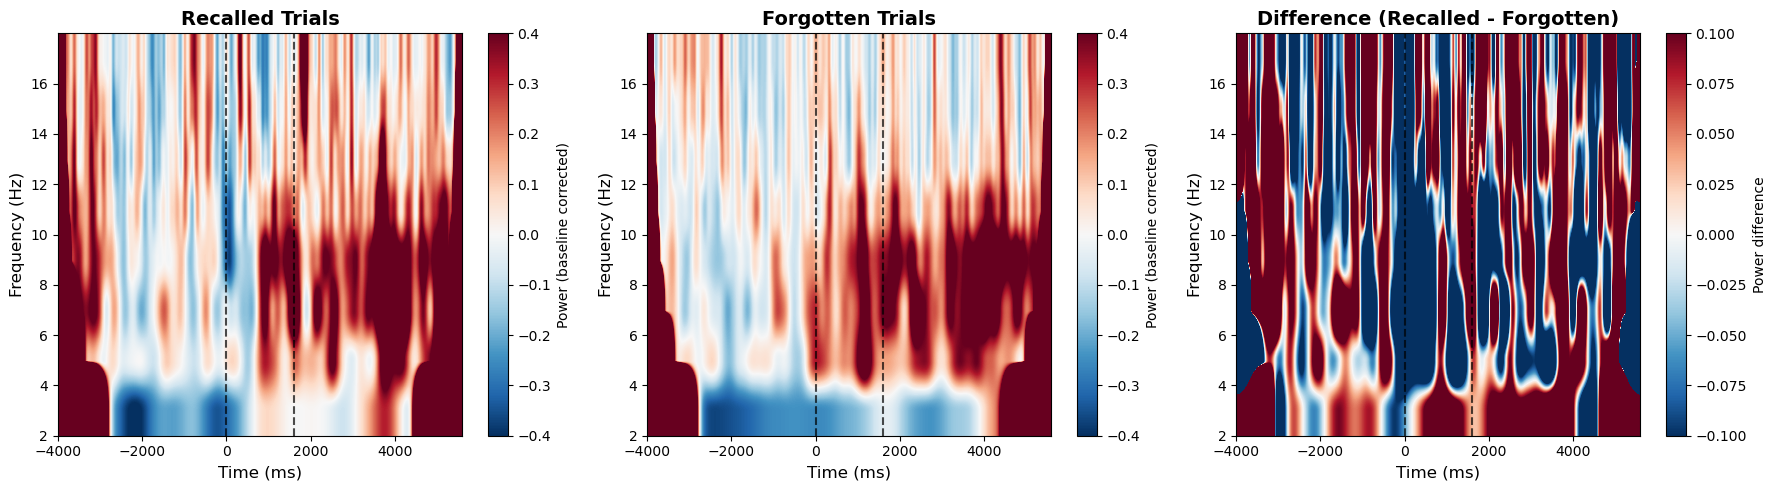

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# After your baseline correction code, add this plotting section:

# ============ PLOTTING ============
print("\nGenerating plots...")

# Average across subjects
avg_recalled = subject_power_8HZ_recalled_baselined.mean(axis=0)  # (freqs, times)
avg_forgotten = subject_power_8HZ_forgotten_baselined.mean(axis=0)  # (freqs, times)
difference = avg_recalled - avg_forgotten  # (freqs, times)

# Create time and frequency arrays for axis labels
freqs = [2, 4, 6, 8, 10, 12, 14, 16]
newfreq = 50  # sampling rate after resampling
n_times = avg_recalled.shape[1]

# Time axis: from -(3000+1000)ms to duration_encoding+3000+1000 ms
time_start_ms = -(3000 + 1000)
time_end_ms = duration_encoding + 3000 + 1000
time_axis = np.linspace(time_start_ms, time_end_ms, n_times)

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Determine symmetric color scale for recalled and forgotten
vmax_power =0.4
vmin_power = -0.4
vmax_diff=0.1
# Plot 1: Recalled
im1 = axes[0].imshow(avg_recalled, aspect='auto', origin='lower', 
                     cmap='RdBu_r', vmin=vmin_power, vmax=vmax_power,
                     extent=[time_axis[0], time_axis[-1], 0, len(freqs)])
axes[0].set_title('Recalled Trials', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (ms)', fontsize=12)
axes[0].set_ylabel('Frequency (Hz)', fontsize=12)
axes[0].set_yticks(np.arange(len(freqs)))
axes[0].set_yticklabels(freqs)
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
axes[0].axvline(x=duration_encoding, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
plt.colorbar(im1, ax=axes[0], label='Power (baseline corrected)')

# Plot 2: Forgotten
im2 = axes[1].imshow(avg_forgotten, aspect='auto', origin='lower',
                     cmap='RdBu_r', vmin=vmin_power, vmax=vmax_power,
                     extent=[time_axis[0], time_axis[-1], 0, len(freqs)])
axes[1].set_title('Forgotten Trials', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (ms)', fontsize=12)
axes[1].set_ylabel('Frequency (Hz)', fontsize=12)
axes[1].set_yticks(np.arange(len(freqs)))
axes[1].set_yticklabels(freqs)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1].axvline(x=duration_encoding, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
plt.colorbar(im2, ax=axes[1], label='Power (baseline corrected)')

# Plot 3: Difference (Recalled - Forgotten)
vmax_diff = max(abs(difference.min()), abs(difference.max()))
im3 = axes[2].imshow(difference, aspect='auto', origin='lower',
                     cmap='RdBu_r', vmin=-0.1, vmax=0.1,
                     extent=[time_axis[0], time_axis[-1], 0, len(freqs)])
axes[2].set_title('Difference (Recalled - Forgotten)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Time (ms)', fontsize=12)
axes[2].set_ylabel('Frequency (Hz)', fontsize=12)
axes[2].set_yticks(np.arange(len(freqs)))
axes[2].set_yticklabels(freqs)
axes[2].axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
axes[2].axvline(x=duration_encoding, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
plt.colorbar(im3, ax=axes[2], label='Power difference')

plt.tight_layout()
plt.savefig('eeg_results/power_comparison.png', dpi=300, bbox_inches='tight')
print(f"Plot saved to: eeg_results/power_comparison.png")
plt.show()



No handles with labels found to put in legend.



Figure saved to: eeg_results/subject_level_tfr_analysis.png


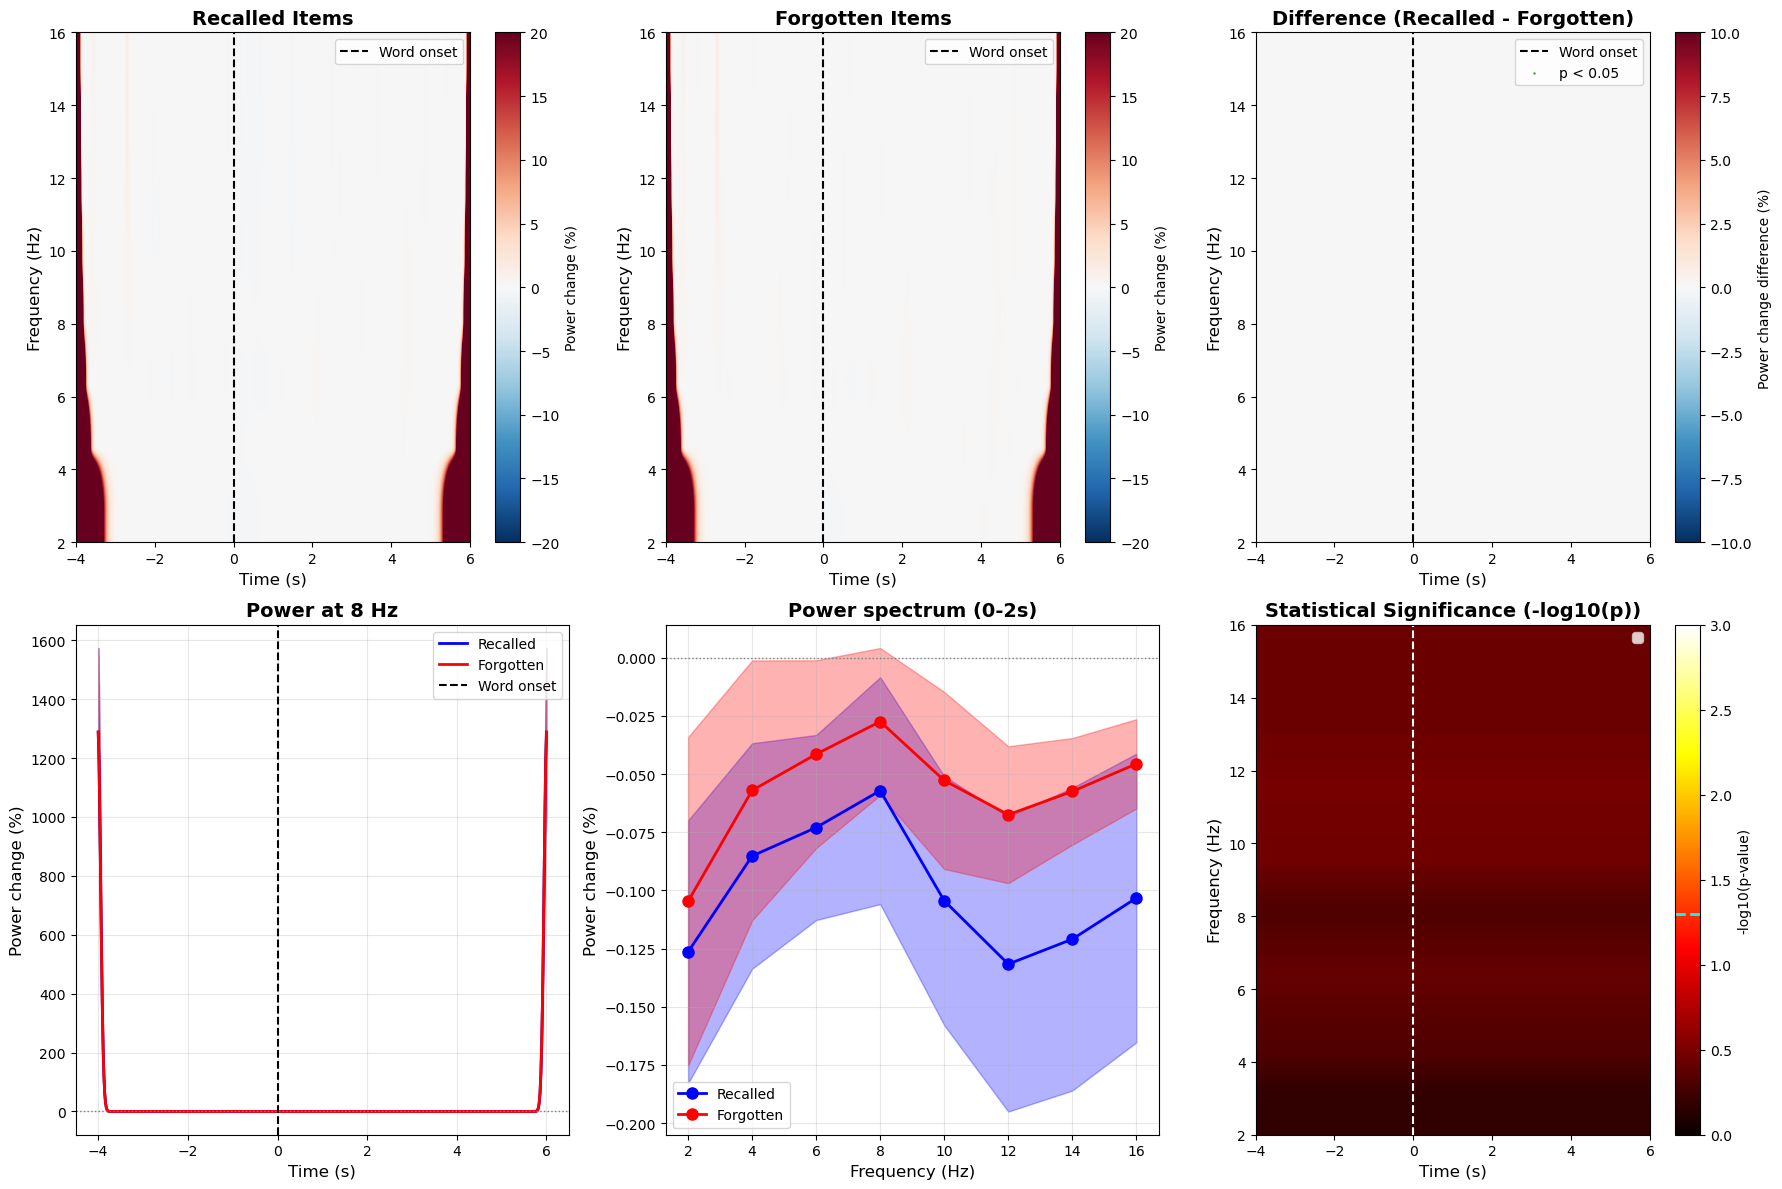


Summary Statistics
Number of subjects: 8
Subjects analyzed: ['R1016M', 'R1024E', 'R1028M', 'R1031M', 'R1036M', 'R1042M', 'R1050M', 'R1060M']

Significant effects (p < 0.05):
  0/4400 time-frequency points (0.00%)

Strongest effect:
  Frequency: 12 Hz
  Time: -3.96 s
  Difference: -0.06%
  p-value: 0.3285


In [30]:
import matplotlib.pyplot as plt
from scipy import stats

# Calculate grand averages across subjects
grand_avg_recalled = subject_power_8HZ_recalled_baselined.mean(axis=0)  # (freqs, times)
grand_avg_forgotten = subject_power_8HZ_forgotten_baselined.mean(axis=0)  # (freqs, times)
difference = grand_avg_recalled - grand_avg_forgotten

# Calculate time axis (in seconds, assuming newfreq=50Hz)
n_timepoints = grand_avg_recalled.shape[1]
time_axis = np.linspace(-(3000+1000)/1000, duration_encoding/1000 + 3000/1000, n_timepoints)

# Frequency axis - convert to numpy array
freq_axis = np.array(freqs)

# Perform paired t-tests at each frequency-time point
t_stats = np.zeros_like(grand_avg_recalled)
p_values = np.zeros_like(grand_avg_recalled)

for freq_idx in range(len(freqs)):
    for time_idx in range(n_timepoints):
        recalled_vals = subject_power_8HZ_recalled_baselined[:, freq_idx, time_idx]
        forgotten_vals = subject_power_8HZ_forgotten_baselined[:, freq_idx, time_idx]
        t_stat, p_val = stats.ttest_rel(recalled_vals, forgotten_vals)
        t_stats[freq_idx, time_idx] = t_stat
        p_values[freq_idx, time_idx] = p_val

# Apply significance threshold (p < 0.05)
significance_mask = p_values < 0.05

# Create figure with multiple subplots
fig = plt.figure(figsize=(18, 12))

# 1. Time-frequency plot for RECALLED
ax1 = plt.subplot(2, 3, 1)
im1 = ax1.imshow(grand_avg_recalled, aspect='auto', origin='lower', cmap='RdBu_r',
                 extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]],
                 vmin=-20, vmax=20)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Frequency (Hz)', fontsize=12)
ax1.set_title('Recalled Items', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label='Word onset')
plt.colorbar(im1, ax=ax1, label='Power change (%)')
ax1.legend()

# 2. Time-frequency plot for FORGOTTEN
ax2 = plt.subplot(2, 3, 2)
im2 = ax2.imshow(grand_avg_forgotten, aspect='auto', origin='lower', cmap='RdBu_r',
                 extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]],
                 vmin=-20, vmax=20)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Frequency (Hz)', fontsize=12)
ax2.set_title('Forgotten Items', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label='Word onset')
plt.colorbar(im2, ax=ax2, label='Power change (%)')
ax2.legend()

# 3. Time-frequency plot for DIFFERENCE (Recalled - Forgotten)
ax3 = plt.subplot(2, 3, 3)
im3 = ax3.imshow(difference, aspect='auto', origin='lower', cmap='RdBu_r',
                 extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]],
                 vmin=-10, vmax=10)
ax3.set_xlabel('Time (s)', fontsize=12)
ax3.set_ylabel('Frequency (Hz)', fontsize=12)
ax3.set_title('Difference (Recalled - Forgotten)', fontsize=14, fontweight='bold')
ax3.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label='Word onset')

# Overlay significant points as dots
sig_freqs, sig_times = np.where(significance_mask)
sig_time_values = time_axis[sig_times]
sig_freq_values = freq_axis[sig_freqs]
ax3.scatter(sig_time_values, sig_freq_values, c='green', s=1, alpha=0.5, label='p < 0.05')

plt.colorbar(im3, ax=ax3, label='Power change difference (%)')
ax3.legend()

# 4. Line plot: Power over time for specific frequency (e.g., 8 Hz)
ax4 = plt.subplot(2, 3, 4)
freq_of_interest = 8  # Hz
freq_idx = np.argmin(np.abs(freq_axis - freq_of_interest))

recalled_trace = grand_avg_recalled[freq_idx, :]
forgotten_trace = grand_avg_forgotten[freq_idx, :]
recalled_sem = stats.sem(subject_power_8HZ_recalled_baselined[:, freq_idx, :], axis=0)
forgotten_sem = stats.sem(subject_power_8HZ_forgotten_baselined[:, freq_idx, :], axis=0)

ax4.plot(time_axis, recalled_trace, 'b-', linewidth=2, label='Recalled')
ax4.fill_between(time_axis, recalled_trace - recalled_sem, recalled_trace + recalled_sem, 
                 alpha=0.3, color='blue')
ax4.plot(time_axis, forgotten_trace, 'r-', linewidth=2, label='Forgotten')
ax4.fill_between(time_axis, forgotten_trace - forgotten_sem, forgotten_trace + forgotten_sem, 
                 alpha=0.3, color='red')
ax4.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label='Word onset')
ax4.axhline(y=0, color='gray', linestyle=':', linewidth=1)
ax4.set_xlabel('Time (s)', fontsize=12)
ax4.set_ylabel('Power change (%)', fontsize=12)
ax4.set_title(f'Power at {freq_of_interest} Hz', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Line plot: Power over frequency at specific time window
ax5 = plt.subplot(2, 3, 5)
# Average over encoding period (e.g., 0 to 2 seconds after word onset)
time_window_start = 0  # seconds
time_window_end = 2    # seconds
time_mask = (time_axis >= time_window_start) & (time_axis <= time_window_end)

recalled_freq = grand_avg_recalled[:, time_mask].mean(axis=1)
forgotten_freq = grand_avg_forgotten[:, time_mask].mean(axis=1)
recalled_freq_sem = stats.sem(subject_power_8HZ_recalled_baselined[:, :, time_mask].mean(axis=2), axis=0)
forgotten_freq_sem = stats.sem(subject_power_8HZ_forgotten_baselined[:, :, time_mask].mean(axis=2), axis=0)

ax5.plot(freq_axis, recalled_freq, 'bo-', linewidth=2, markersize=8, label='Recalled')
ax5.fill_between(freq_axis, recalled_freq - recalled_freq_sem, recalled_freq + recalled_freq_sem, 
                 alpha=0.3, color='blue')
ax5.plot(freq_axis, forgotten_freq, 'ro-', linewidth=2, markersize=8, label='Forgotten')
ax5.fill_between(freq_axis, forgotten_freq - forgotten_freq_sem, forgotten_freq + forgotten_freq_sem, 
                 alpha=0.3, color='red')
ax5.axhline(y=0, color='gray', linestyle=':', linewidth=1)
ax5.set_xlabel('Frequency (Hz)', fontsize=12)
ax5.set_ylabel('Power change (%)', fontsize=12)
ax5.set_title(f'Power spectrum ({time_window_start}-{time_window_end}s)', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Statistical significance heatmap (p-values)
ax6 = plt.subplot(2, 3, 6)

im6 = ax6.imshow(-np.log10(p_values), aspect='auto', origin='lower', cmap='hot',
                 extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]],
                 vmin=0, vmax=3)
ax6.set_xlabel('Time (s)', fontsize=12)
ax6.set_ylabel('Frequency (Hz)', fontsize=12)
ax6.set_title('Statistical Significance (-log10(p))', fontsize=14, fontweight='bold')
ax6.axvline(x=0, color='white', linestyle='--', linewidth=1.5)

# Overlay significant points as dots
#ax6.scatter(sig_time_values, sig_freq_values, c='cyan', s=1, alpha=0.5, label='p < 0.05')

cbar = plt.colorbar(im6, ax=ax6, label='-log10(p-value)')
cbar.ax.axhline(y=-np.log10(0.05), color='cyan', linestyle='--', linewidth=2)
ax6.legend()

plt.tight_layout()
plt.savefig('eeg_results/subject_level_tfr_analysis.png', dpi=300, bbox_inches='tight')
print("\nFigure saved to: eeg_results/subject_level_tfr_analysis.png")
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("Summary Statistics")
print("="*60)
print(f"Number of subjects: {len(subject_ids)}")
print(f"Subjects analyzed: {subject_ids}")
print(f"\nSignificant effects (p < 0.05):")
sig_count = significance_mask.sum()
total_tests = significance_mask.size
print(f"  {sig_count}/{total_tests} time-frequency points ({100*sig_count/total_tests:.2f}%)")

# Find time-frequency points with strongest effects
max_diff_idx = np.unravel_index(np.argmax(np.abs(difference)), difference.shape)
max_freq = freqs[max_diff_idx[0]]
max_time = time_axis[max_diff_idx[1]]
max_diff_val = difference[max_diff_idx]
max_pval = p_values[max_diff_idx]
print(f"\nStrongest effect:")
print(f"  Frequency: {max_freq} Hz")
print(f"  Time: {max_time:.2f} s")
print(f"  Difference: {max_diff_val:.2f}%")
print(f"  p-value: {max_pval:.4f}")


Figure saved to: eeg_results/subject_level_tfr_analysis_1236.png


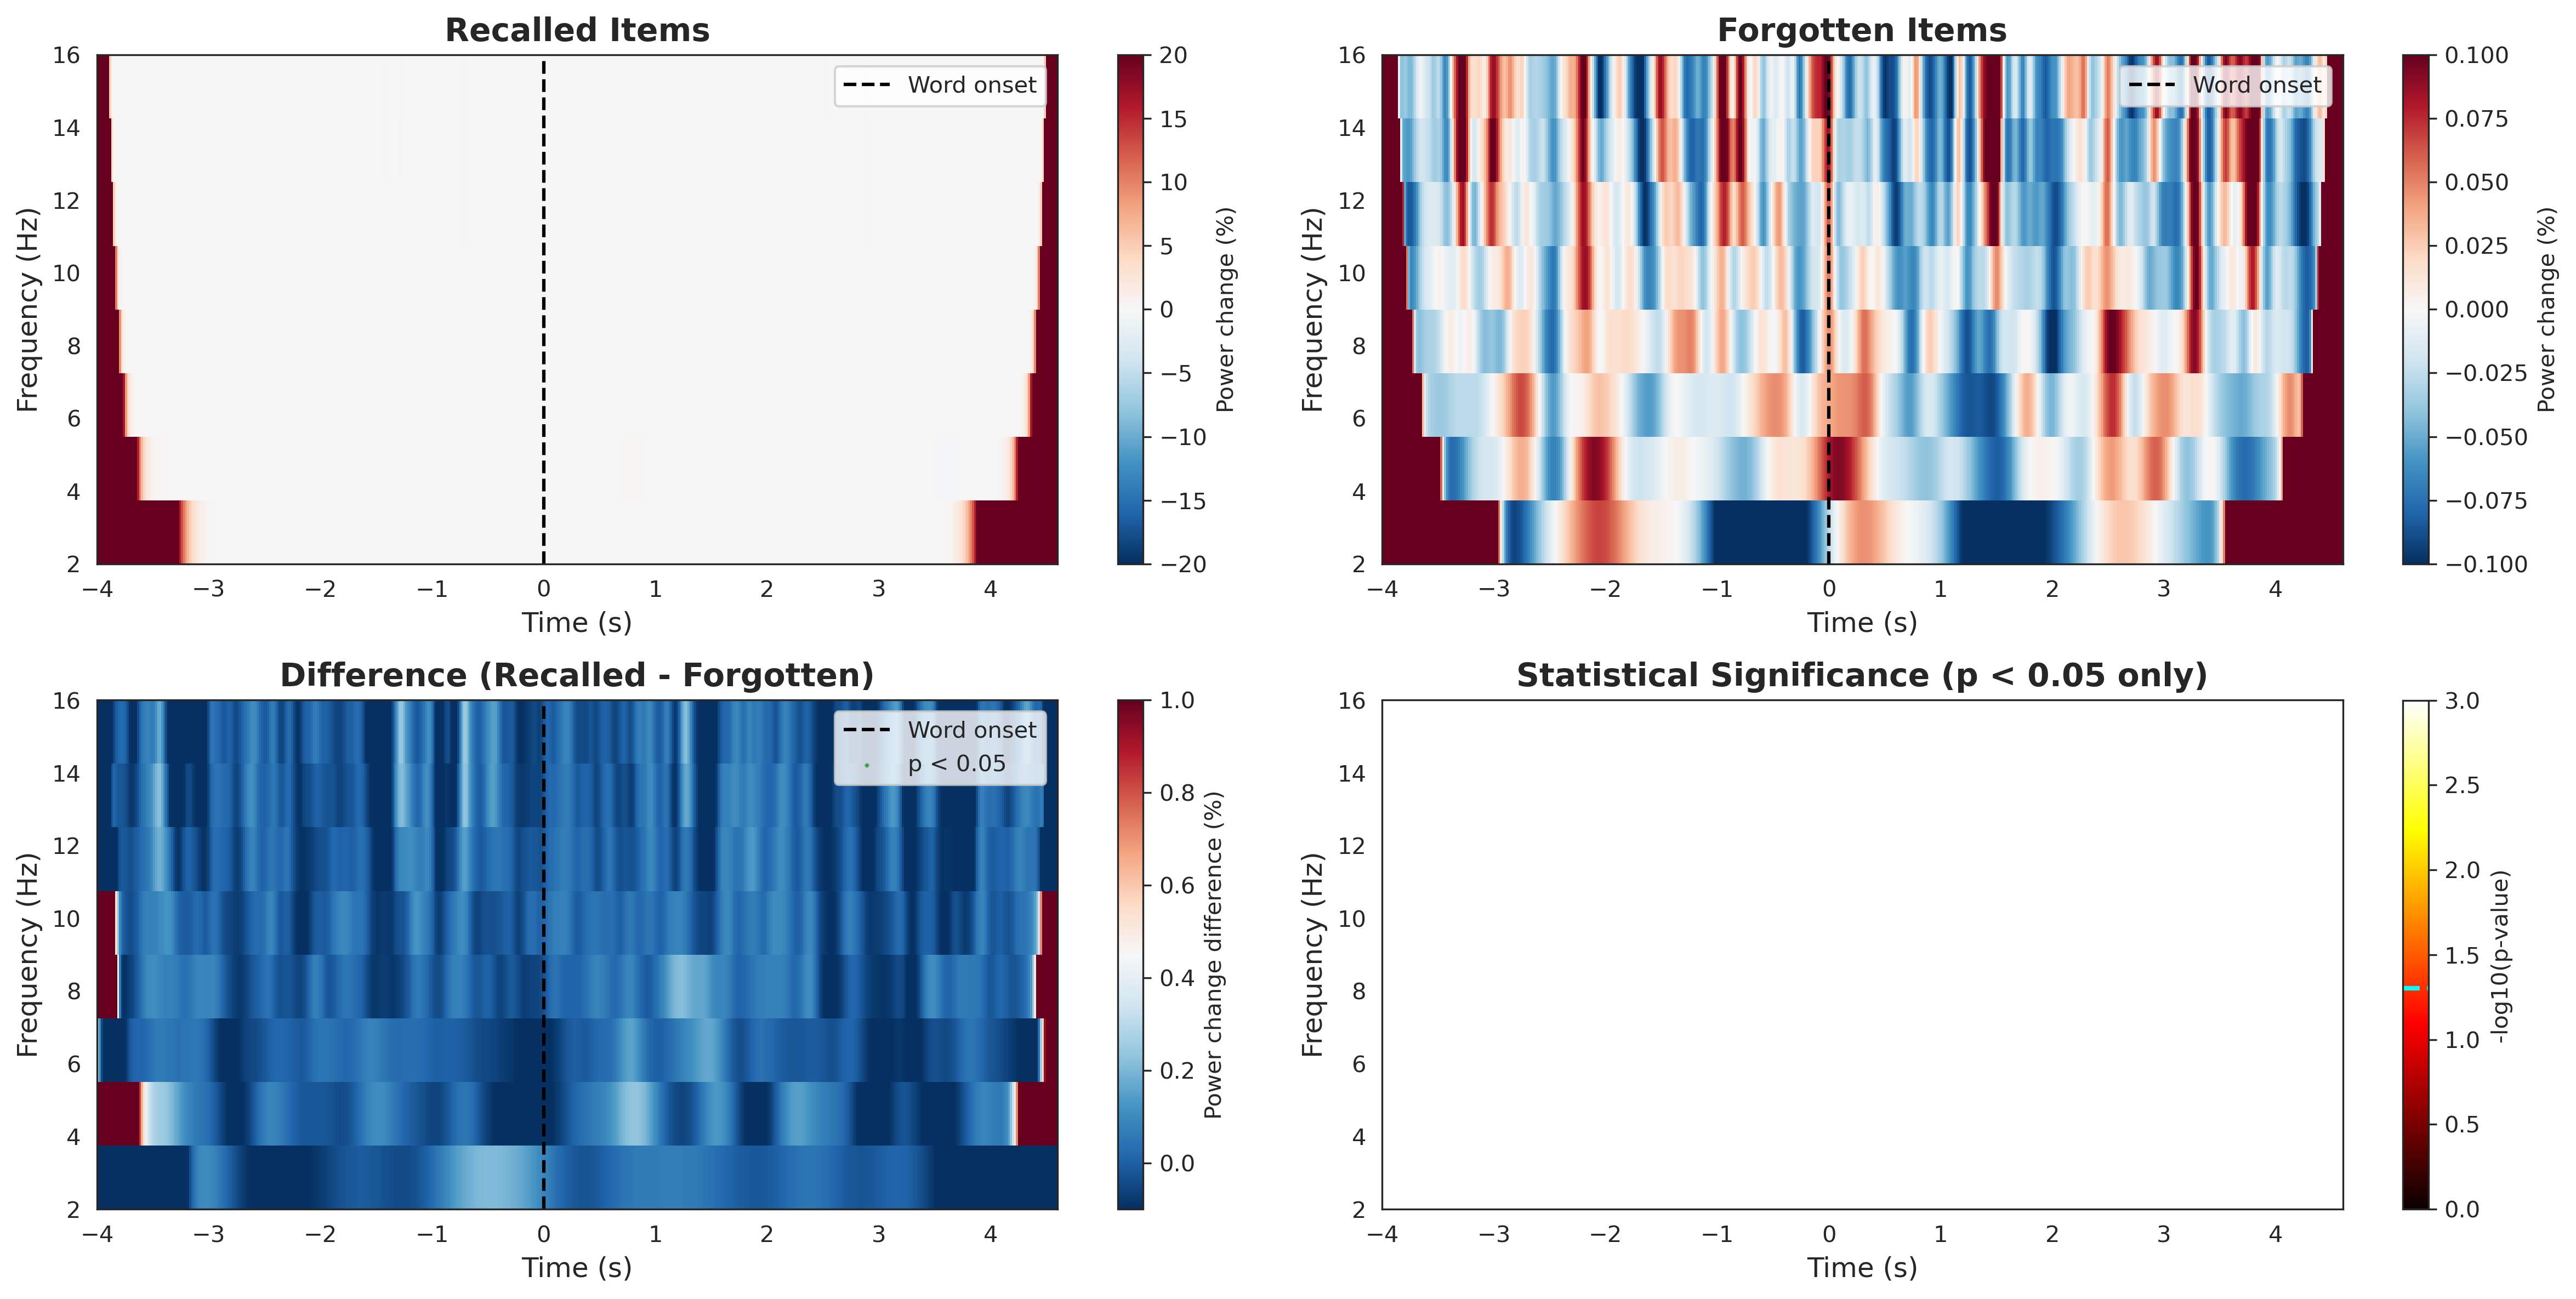


Summary Statistics
Number of subjects: 1
Subjects analyzed: ['R1184M']

Significant effects (p < 0.05):
  0/3840 time-frequency points (0.00%)

Strongest effect:
  Frequency: 16 Hz
  Time: 4.60 s
  Difference: -203.99%
  p-value: nan


In [65]:
import matplotlib.pyplot as plt
from scipy import stats

# Calculate grand averages across subjects
grand_avg_recalled = subject_power_8HZ_recalled_baselined.mean(axis=0)  # (freqs, times)
grand_avg_forgotten = subject_power_8HZ_forgotten_baselined.mean(axis=0)  # (freqs, times)
difference = grand_avg_recalled - grand_avg_forgotten

# Calculate time axis (in seconds, assuming newfreq=50Hz)
n_timepoints = grand_avg_recalled.shape[1]
time_axis = np.linspace(-(3000+1000)/1000, duration_encoding/1000 + 3000/1000, n_timepoints)

# Frequency axis - convert to numpy array
freq_axis = np.array(freqs)

# Perform paired t-tests at each frequency-time point
t_stats = np.zeros_like(grand_avg_recalled)
p_values = np.zeros_like(grand_avg_recalled)

for freq_idx in range(len(freqs)):
    for time_idx in range(n_timepoints):
        recalled_vals = subject_power_8HZ_recalled_baselined[:, freq_idx, time_idx]
        forgotten_vals = subject_power_8HZ_forgotten_baselined[:, freq_idx, time_idx]
        t_stat, p_val = stats.ttest_rel(recalled_vals, forgotten_vals)
        t_stats[freq_idx, time_idx] = t_stat
        p_values[freq_idx, time_idx] = p_val

# Apply significance threshold (p < 0.05)
significance_mask = p_values < 0.05

# Create figure with 4 subplots (plots 1, 2, 3, and 6)
fig = plt.figure(figsize=(16, 8))

# 1. Time-frequency plot for RECALLED
ax1 = plt.subplot(2, 2, 1)
im1 = ax1.imshow(grand_avg_recalled, aspect='auto', origin='lower', cmap='RdBu_r',
                 extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]],
                 vmin=-20, vmax=20)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Frequency (Hz)', fontsize=12)
ax1.set_title('Recalled Items', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label='Word onset')
plt.colorbar(im1, ax=ax1, label='Power change (%)')
ax1.legend()

# 2. Time-frequency plot for FORGOTTEN
ax2 = plt.subplot(2, 2, 2)
im2 = ax2.imshow(grand_avg_forgotten, aspect='auto', origin='lower', cmap='RdBu_r',
                 extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]],
                 vmin=-0.1, vmax=0.1)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Frequency (Hz)', fontsize=12)
ax2.set_title('Forgotten Items', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label='Word onset')
plt.colorbar(im2, ax=ax2, label='Power change (%)')
ax2.legend()

# 3. Time-frequency plot for DIFFERENCE (Recalled - Forgotten)
ax3 = plt.subplot(2, 2, 3)
im3 = ax3.imshow(difference, aspect='auto', origin='lower', cmap='RdBu_r',
                 extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]],
                 vmin=-0.1, vmax=1)
ax3.set_xlabel('Time (s)', fontsize=12)
ax3.set_ylabel('Frequency (Hz)', fontsize=12)
ax3.set_title('Difference (Recalled - Forgotten)', fontsize=14, fontweight='bold')
ax3.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label='Word onset')

# Overlay significant points as dots
sig_freqs, sig_times = np.where(significance_mask)
sig_time_values = time_axis[sig_times]
sig_freq_values = freq_axis[sig_freqs]
ax3.scatter(sig_time_values, sig_freq_values, c='green', s=1, alpha=0.5, label='p < 0.05')

plt.colorbar(im3, ax=ax3, label='Power change difference (%)')
ax3.legend()

# 6. Statistical significance heatmap (p-values) - ONLY SHOW p < 0.05
ax6 = plt.subplot(2, 2, 4)

# Create a masked version that only shows significant p-values
p_values_masked = np.where(p_values < 0.05, -np.log10(p_values), np.nan)

im6 = ax6.imshow(p_values_masked, aspect='auto', origin='lower', cmap='hot',
                 extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]],
                 vmin=0, vmax=3)
ax6.set_xlabel('Time (s)', fontsize=12)
ax6.set_ylabel('Frequency (Hz)', fontsize=12)
ax6.set_title('Statistical Significance (p < 0.05 only)', fontsize=14, fontweight='bold')
ax6.axvline(x=0, color='white', linestyle='--', linewidth=1.5)

cbar = plt.colorbar(im6, ax=ax6, label='-log10(p-value)')
cbar.ax.axhline(y=-np.log10(0.05), color='cyan', linestyle='--', linewidth=2)

plt.tight_layout()
plt.savefig('eeg_results/subject_level_tfr_analysis_1236.png', dpi=300, bbox_inches='tight')
print("\nFigure saved to: eeg_results/subject_level_tfr_analysis_1236.png")
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("Summary Statistics")
print("="*60)
print(f"Number of subjects: {len(subject_ids)}")
print(f"Subjects analyzed: {subject_ids}")
print(f"\nSignificant effects (p < 0.05):")
sig_count = significance_mask.sum()
total_tests = significance_mask.size
print(f"  {sig_count}/{total_tests} time-frequency points ({100*sig_count/total_tests:.2f}%)")

# Find time-frequency points with strongest effects
max_diff_idx = np.unravel_index(np.argmax(np.abs(difference)), difference.shape)
max_freq = freqs[max_diff_idx[0]]
max_time = time_axis[max_diff_idx[1]]
max_diff_val = difference[max_diff_idx]
max_pval = p_values[max_diff_idx]
print(f"\nStrongest effect:")
print(f"  Frequency: {max_freq} Hz")
print(f"  Time: {max_time:.2f} s")
print(f"  Difference: {max_diff_val:.2f}%")
print(f"  p-value: {max_pval:.4f}")

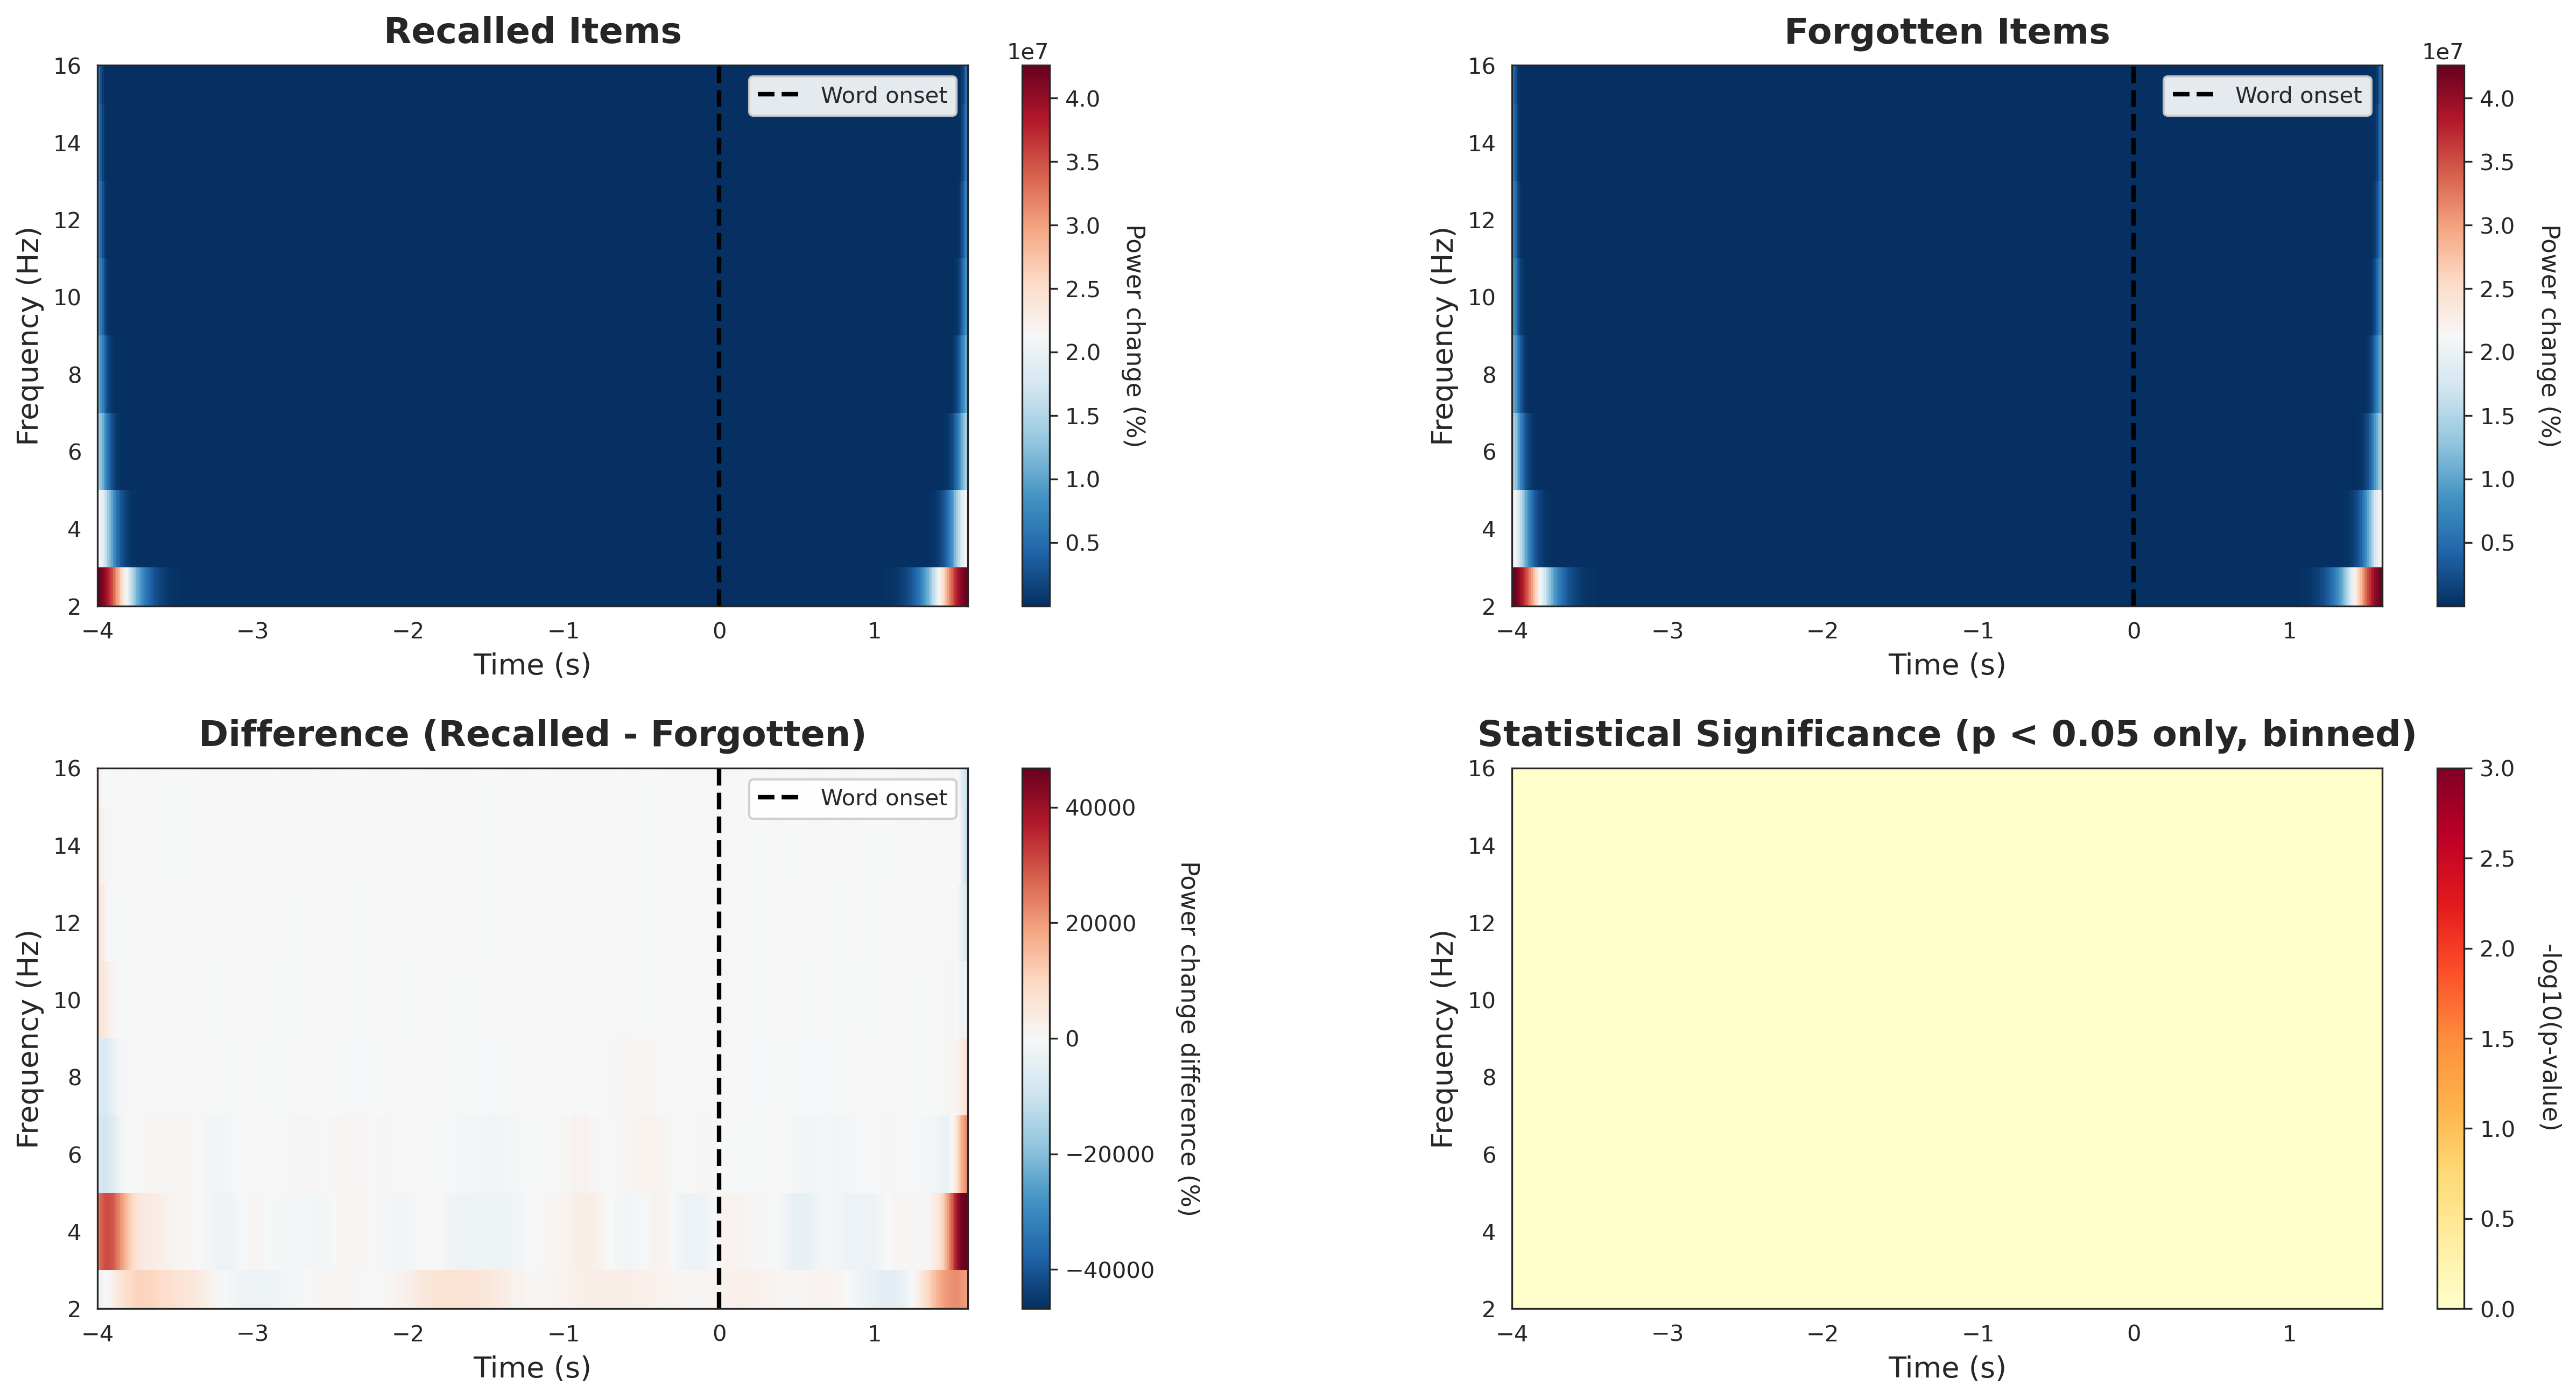

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/numpy/core/_methods.py:252: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/numpy/core/_methods.py:252: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, wh

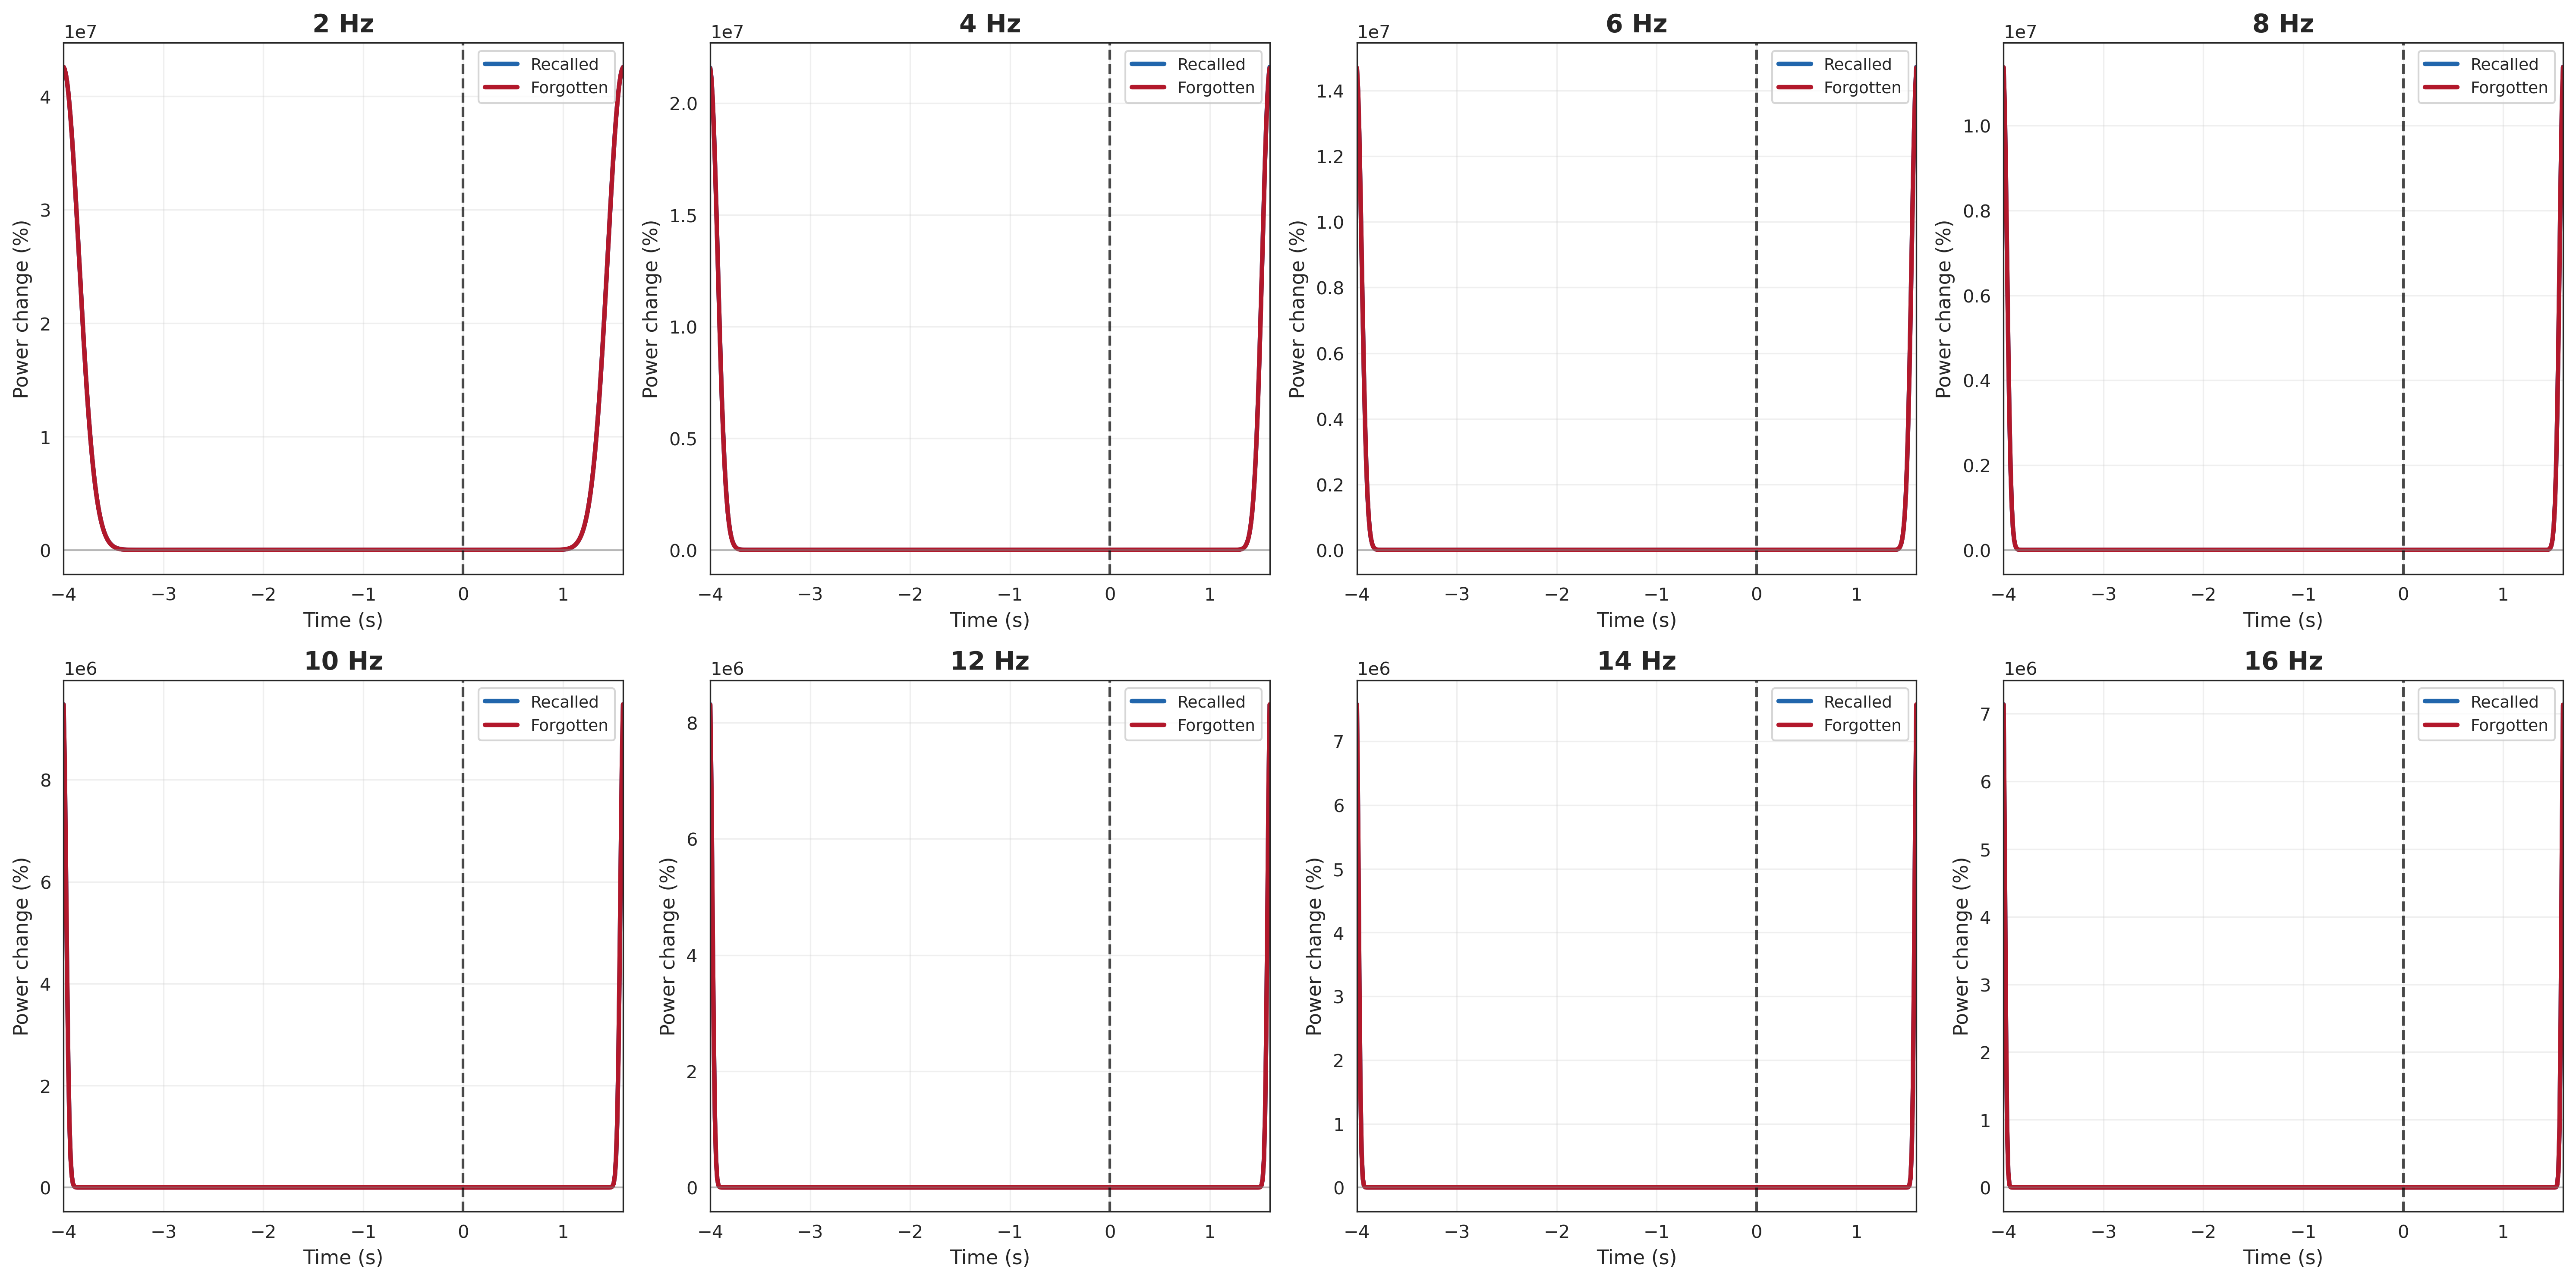


STATISTICAL SUMMARY
Number of subjects: 1

Time range: -4.00 to 1.60 seconds
Frequency range: 2 to 16 Hz

------------------------------------------------------------
Significant differences during encoding (0-1.6 s):
------------------------------------------------------------


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Set style
sns.set_style("white")
plt.rcParams['figure.dpi'] = 300

# ============ SETUP ============
# Define time and frequency parameters
freqs = np.array([2, 4, 6, 8, 10, 12, 14, 16])
newfreq = 50  # sampling rate after resampling
tmin = -(3000+1000) / 1000.0  # in seconds
duration_total = (1600 + 3000 + 1000) / 1000.0  # total duration in seconds
n_times = subject_power_8HZ_recalled.shape[2]
times = np.linspace(tmin, tmin + duration_total, n_times)

# Convert to seconds for plotting (matching your image)
times_s = times

# ============ CREATE MAIN FIGURE ============
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# ============ CALCULATE DATA ============
# Average across subjects
avg_recalled = subject_power_8HZ_recalled.mean(axis=0)
avg_forgotten = subject_power_8HZ_forgotten.mean(axis=0)
difference = avg_recalled - avg_forgotten

# Calculate t-statistics at each time-frequency point
t_stats = np.zeros((len(freqs), n_times))
p_values = np.zeros((len(freqs), n_times))

for freq_idx in range(len(freqs)):
    for time_idx in range(n_times):
        recalled_vals = subject_power_8HZ_recalled[:, freq_idx, time_idx]
        forgotten_vals = subject_power_8HZ_forgotten[:, freq_idx, time_idx]
        t_stat, p_val = stats.ttest_rel(recalled_vals, forgotten_vals)
        t_stats[freq_idx, time_idx] = t_stat
        p_values[freq_idx, time_idx] = p_val

# Create significance mask
significant = p_values < 0.05

# ============ PLOT 1: RECALLED ITEMS ============
ax1 = fig.add_subplot(gs[0, 0])
vmin_data = min(avg_recalled.min(), avg_forgotten.min())
vmax_data = max(avg_recalled.max(), avg_forgotten.max())

im1 = ax1.pcolormesh(times_s, freqs, avg_recalled, 
                      cmap='RdBu_r', shading='auto', 
                      vmin=vmin_data, vmax=vmax_data)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Word onset')
ax1.set_title('Recalled Items', fontsize=16, fontweight='bold', pad=10)
ax1.set_xlabel('Time (s)', fontsize=13)
ax1.set_ylabel('Frequency (Hz)', fontsize=13)
ax1.set_xlim([times_s.min(), times_s.max()])
ax1.set_ylim([freqs.min(), freqs.max()])
ax1.legend(loc='upper right', fontsize=10, framealpha=0.9)

# Add colorbar
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Power change (%)', fontsize=11, rotation=270, labelpad=20)

# ============ PLOT 2: FORGOTTEN ITEMS ============
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.pcolormesh(times_s, freqs, avg_forgotten, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin_data, vmax=vmax_data)
ax2.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Word onset')
ax2.set_title('Forgotten Items', fontsize=16, fontweight='bold', pad=10)
ax2.set_xlabel('Time (s)', fontsize=13)
ax2.set_ylabel('Frequency (Hz)', fontsize=13)
ax2.set_xlim([times_s.min(), times_s.max()])
ax2.set_ylim([freqs.min(), freqs.max()])
ax2.legend(loc='upper right', fontsize=10, framealpha=0.9)

# Add colorbar
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('Power change (%)', fontsize=11, rotation=270, labelpad=20)

# ============ PLOT 3: DIFFERENCE (RECALLED - FORGOTTEN) ============
ax3 = fig.add_subplot(gs[1, 0])
vmax_diff = np.abs(difference).max()
im3 = ax3.pcolormesh(times_s, freqs, difference, 
                      cmap='RdBu_r', shading='auto',
                      vmin=-vmax_diff, vmax=vmax_diff)
ax3.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Word onset')

# Add significance contours (green outline)
if significant.any():
    contours = ax3.contour(times_s, freqs, significant, 
                           levels=[0.5], colors='green', 
                           linewidths=2, linestyles='solid')

ax3.set_title('Difference (Recalled - Forgotten)', fontsize=16, fontweight='bold', pad=10)
ax3.set_xlabel('Time (s)', fontsize=13)
ax3.set_ylabel('Frequency (Hz)', fontsize=13)
ax3.set_xlim([times_s.min(), times_s.max()])
ax3.set_ylim([freqs.min(), freqs.max()])
ax3.legend(['Word onset', 'p < 0.05'], loc='upper right', fontsize=10, framealpha=0.9)

# Add colorbar
cbar3 = plt.colorbar(im3, ax=ax3)
cbar3.set_label('Power change difference (%)', fontsize=11, rotation=270, labelpad=20)

# ============ PLOT 4: STATISTICAL SIGNIFICANCE (BINNED) ============
ax4 = fig.add_subplot(gs[1, 1])

# Create binned visualization of -log10(p-values) for significant regions only
log_p_values = -np.log10(p_values)
log_p_values[~significant] = 0  # Set non-significant to 0

# Create discrete color representation
im4 = ax4.pcolormesh(times_s, freqs, log_p_values, 
                      cmap='YlOrRd', shading='auto',
                      vmin=0, vmax=3)
ax4.set_title('Statistical Significance (p < 0.05 only, binned)', 
              fontsize=16, fontweight='bold', pad=10)
ax4.set_xlabel('Time (s)', fontsize=13)
ax4.set_ylabel('Frequency (Hz)', fontsize=13)
ax4.set_xlim([times_s.min(), times_s.max()])
ax4.set_ylim([freqs.min(), freqs.max()])

# Add colorbar
cbar4 = plt.colorbar(im4, ax=ax4)
cbar4.set_label('-log10(p-value)', fontsize=11, rotation=270, labelpad=20)

plt.savefig('eeg_results/comprehensive_analysis.png', bbox_inches='tight', dpi=300)
plt.show()

# ============ ADDITIONAL PLOT: FREQUENCY-SPECIFIC TIME COURSES ============
fig2, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, freq in enumerate(freqs):
    ax = axes[idx]
    
    # Get data for this frequency across all subjects
    recalled_freq = subject_power_8HZ_recalled[:, idx, :]
    forgotten_freq = subject_power_8HZ_forgotten[:, idx, :]
    
    # Calculate mean and SEM
    recalled_mean = recalled_freq.mean(axis=0)
    recalled_sem = stats.sem(recalled_freq, axis=0)
    forgotten_mean = forgotten_freq.mean(axis=0)
    forgotten_sem = stats.sem(forgotten_freq, axis=0)
    
    # Plot with error bars
    ax.plot(times_s, recalled_mean, color='#2166ac', linewidth=2.5, label='Recalled')
    ax.fill_between(times_s, recalled_mean - recalled_sem, recalled_mean + recalled_sem, 
                     color='#2166ac', alpha=0.3)
    
    ax.plot(times_s, forgotten_mean, color='#b2182b', linewidth=2.5, label='Forgotten')
    ax.fill_between(times_s, forgotten_mean - forgotten_sem, forgotten_mean + forgotten_sem, 
                     color='#b2182b', alpha=0.3)
    
    # Add reference lines
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    
    # Highlight significant regions
    sig_mask = significant[idx, :]
    if sig_mask.any():
        y_range = ax.get_ylim()
        for i in range(len(sig_mask)):
            if sig_mask[i]:
                ax.axvspan(times_s[max(0, i-1)], times_s[min(len(times_s)-1, i+1)], 
                          alpha=0.2, color='green')
    
    ax.set_title(f'{freq} Hz', fontsize=14, fontweight='bold')
    ax.set_xlabel('Time (s)', fontsize=11)
    ax.set_ylabel('Power change (%)', fontsize=11)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([times_s.min(), times_s.max()])

plt.tight_layout()
plt.savefig('eeg_results/frequency_specific_timecourses.png', bbox_inches='tight', dpi=300)
plt.show()

# ============ PRINT STATISTICS ============
print("\n" + "="*60)
print("STATISTICAL SUMMARY")
print("="*60)
print(f"Number of subjects: {len(subject_ids)}")
print(f"\nTime range: {times_s.min():.2f} to {times_s.max():.2f} seconds")
print(f"Frequency range: {freqs.min()} to {freqs.max()} Hz")

# Report significant effects during encoding (0 to 1.6 seconds)
encoding_mask = (times_s >= 0) & (times_s <= 1.6)
print("\n" + "-"*60)
print("Significant differences during encoding (0-1.6 s):")
print("-"*60)

for freq_idx, freq in enumerate(freqs):
    # Check if there are any significant time points for this frequency
    n_sig_points = significant[freq_idx, encoding_mask].sum()
    if n_sig_points > 0:
        # Calculate average effect during encoding
        recalled_enc = subject_power_8HZ_recalled[:, freq_idx, encoding_mask].mean(axis=1)
        forgotten_enc = subject_power_8HZ_forgotten[:, freq_idx, encoding_mask].mean(axis=1)
        t_stat, p_val = stats.ttest_rel(recalled_enc, forgotten_enc)

In [40]:
np.concatenate(subject_recalled_power, axis=0)

ValueError: need at least one array to concatenate

In [43]:
power

NameError: name 'power' is not defined

In [44]:
power_eeg_encoding_epochs

NameError: name 'power_eeg_encoding_epochs' is not defined

In [ ]:
    power_eeg_encoding_epochs = mne.time_frequency.tfr_morlet(
                    eeg_encoding_epochs, 
                    freqs=freqs, 
                    n_cycles=5, 
                    return_itc=False, 
                    average=False,
                    verbose=False
                )